In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import log_loss
from tqdm.auto import tqdm

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

/home/denis/iasa_nlp_labs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load train data
train_df = pd.read_csv('./data/feedback-prize-effectiveness/train.csv')

# Display basic info
print(f"Train data shape: {train_df.shape}")
train_df.head()

Train data shape: (36765, 5)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [3]:
# Check column types
train_df.info()

# Check for missing values
print("\nMissing values per column:")
print(train_df.isnull().sum())

# Basic statistics for text length
train_df['text_length'] = train_df['discourse_text'].str.len()
print("\nText length statistics:")
print(train_df['text_length'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB

Missing values per column:
discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

Text length statistics:
count    36765.000000
mean       249.319652
std        262.652668
min          4.000000
25%         87.000000
50%        155.000000
75%        315.000000
max       4099.000000
Name: text_length, dtype: float64


In [5]:
# Find the shortest discourse element
shortest = train_df.loc[train_df['text_length'].idxmin()]

print("\nShortest discourse element:")
print(f"Text: '{shortest['discourse_text']}'")
print(f"Length: {shortest['text_length']} characters")
print(f"Discourse type: {shortest['discourse_type']}")
print(f"Effectiveness: {shortest['discourse_effectiveness']}")
print(f"Essay ID: {shortest['essay_id']}")

# Let's also see other short discourse elements
very_short = train_df[train_df['text_length'] < 10].sort_values('text_length')
print("\nVery short discourse elements (less than 10 characters):")
print(very_short[['discourse_text', 'text_length', 'discourse_type', 'discourse_effectiveness']])


Shortest discourse element:
Text: 'yes '
Length: 4 characters
Discourse type: Position
Effectiveness: Ineffective
Essay ID: A67828F23302

Very short discourse elements (less than 10 characters):
      discourse_text  text_length discourse_type discourse_effectiveness
26718           yes             4       Position             Ineffective
2909          bills             6          Claim                Adequate
20534         safe,             6          Claim             Ineffective
22782         order             6          Claim             Ineffective
21922        chores             7          Claim               Effective
19291        health             7          Claim               Effective
20323        error,             7          Claim                Adequate
7413        privacy             8          Claim                Adequate
35968       choices             8          Claim             Ineffective
34373       hackers             8          Claim               Effective
2

In [13]:
# Define outlier thresholds using percentiles
lower_bound = train_df['text_length'].quantile(0.01)
upper_bound = train_df['text_length'].quantile(0.99)

# Filter dataset to remove outliers
filtered_df = train_df[(train_df['text_length'] >= lower_bound) & 
                       (train_df['text_length'] <= upper_bound)]

print(f"Original dataset size: {len(train_df)}")
print(f"After removing outliers: {len(filtered_df)} ({len(filtered_df)/len(train_df)*100:.1f}% of original)")
print(f"Removed {len(train_df) - len(filtered_df)} outliers")

# Text length statistics after removing outliers
print("\nText length statistics after removing outliers (1-99 percentile):")
print(filtered_df['text_length'].describe())

# Get statistics by discourse type
print("\nMedian text length by discourse type (after removing outliers):")
median_by_type = filtered_df.groupby('discourse_type')['text_length'].median().sort_values(ascending=False)
for discourse_type, median_length in median_by_type.items():
    print(f"{discourse_type}: {median_length:.0f} characters")

# Get statistics by effectiveness
print("\nMedian text length by effectiveness (after removing outliers):")
median_by_effectiveness = filtered_df.groupby('discourse_effectiveness')['text_length'].median().sort_values(ascending=False)
for effectiveness, median_length in median_by_effectiveness.items():
    print(f"{effectiveness}: {median_length:.0f} characters")

Original dataset size: 36765
After removing outliers: 36037 (98.0% of original)
Removed 728 outliers

Text length statistics after removing outliers (1-99 percentile):
count    36037.000000
mean       237.524572
std        219.716251
min         22.000000
25%         88.000000
50%        155.000000
75%        310.000000
max       1265.000000
Name: text_length, dtype: float64

Median text length by discourse type (after removing outliers):
Evidence: 329 characters
Concluding Statement: 287 characters
Lead: 255 characters
Rebuttal: 131 characters
Counterclaim: 114 characters
Claim: 96 characters
Position: 91 characters

Median text length by effectiveness (after removing outliers):
Effective: 221 characters
Ineffective: 159 characters
Adequate: 135 characters


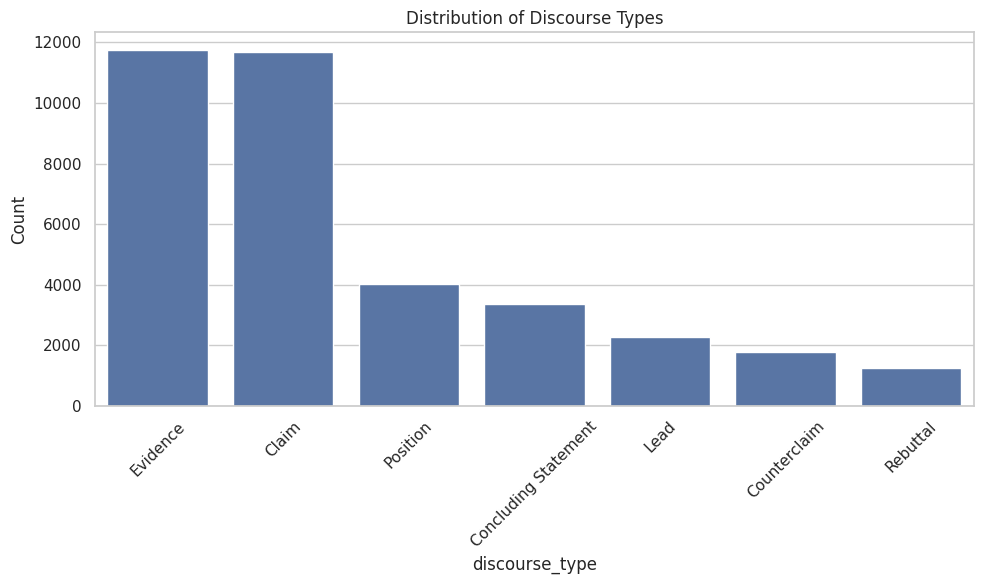


Percentage of each discourse type:
         discourse_type  percentage
0              Evidence   32.599828
1                 Claim   32.383384
2              Position   11.105253
3  Concluding Statement    9.279352
4                  Lead    6.324056
5          Counterclaim    4.903294
6              Rebuttal    3.404834


In [ ]:
# Count discourse types
discourse_counts = train_df['discourse_type'].value_counts()

# Plot discourse type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=discourse_counts.index, y=discourse_counts.values)
plt.title('Distribution of Discourse Types')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate percentages
discourse_percentages = (discourse_counts / len(train_df) * 100).reset_index()
discourse_percentages.columns = ['discourse_type', 'percentage']
print("\nPercentage of each discourse type:")
print(discourse_percentages)

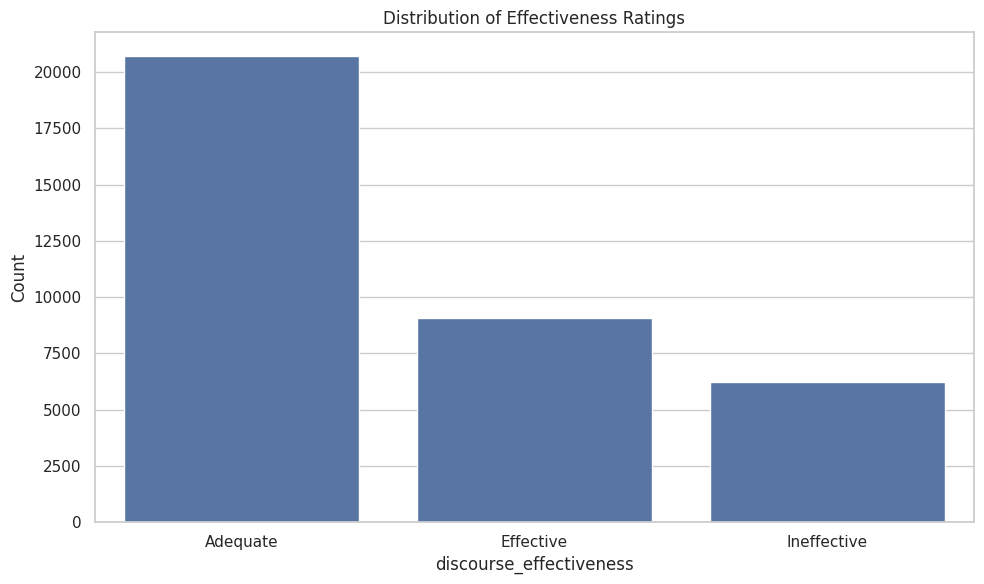


Percentage of each effectiveness rating:
  effectiveness  percentage
0      Adequate   57.540861
1     Effective   25.151927
2   Ineffective   17.307212


In [ ]:
# Count effectiveness ratings
effectiveness_counts = train_df['discourse_effectiveness'].value_counts()

# Plot effectiveness distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=effectiveness_counts.index, y=effectiveness_counts.values)
plt.title('Distribution of Effectiveness Ratings')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate percentages
effectiveness_percentages = (effectiveness_counts / len(train_df) * 100).reset_index()
effectiveness_percentages.columns = ['effectiveness', 'percentage']
print("\nPercentage of each effectiveness rating:")
print(effectiveness_percentages)

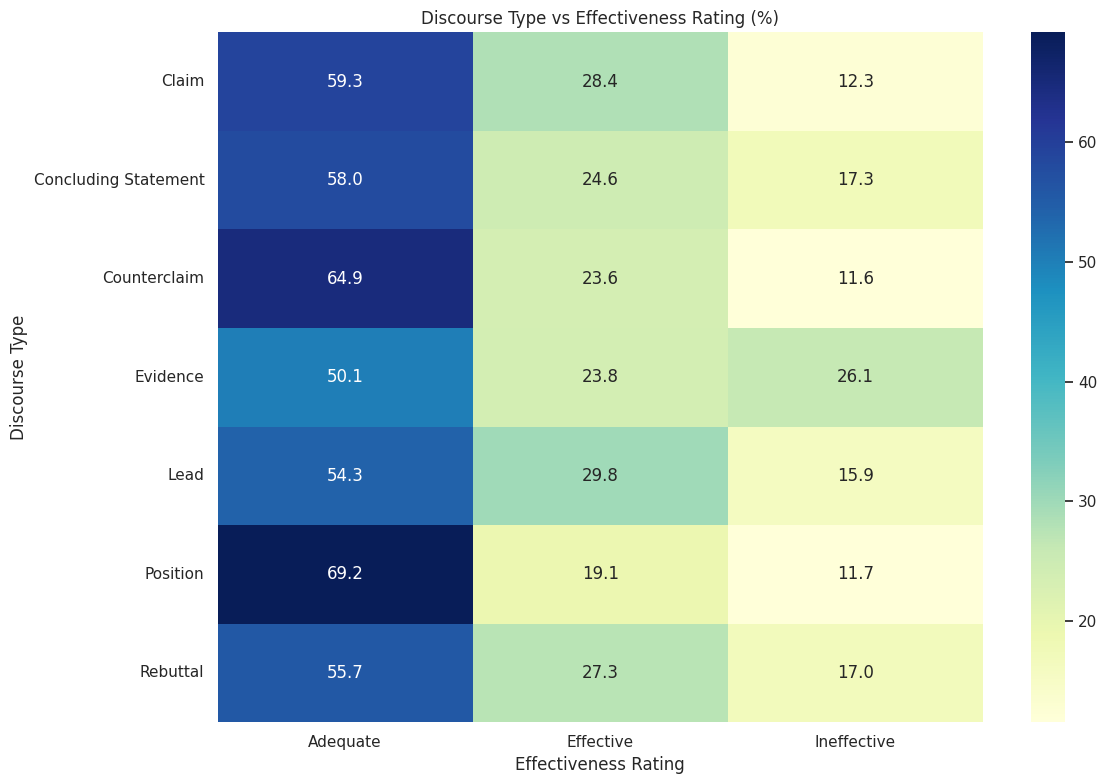

In [8]:
# Create a crosstab of discourse type vs effectiveness
cross_tab = pd.crosstab(
    train_df['discourse_type'], 
    train_df['discourse_effectiveness'], 
    normalize='index'
) * 100

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Discourse Type vs Effectiveness Rating (%)')
plt.ylabel('Discourse Type')
plt.xlabel('Effectiveness Rating')
plt.tight_layout()
plt.show()

Comparison of Outlier Removal Methods:
1. Original IQR (1.5 * IQR):
   - Upper bound: 657.0
   - Removed: 2679 samples (7.29%)

   Statistics after IQR (1.5) outlier removal:
count    34086.000000
mean       193.130083
std        147.904077
min          4.000000
25%         83.000000
50%        142.000000
75%        265.000000
max        657.000000
Name: text_length, dtype: float64

2. Conservative IQR (3.0 * IQR):
   - Upper bound: 999.0
   - Removed: 823 samples (2.24%)

   Statistics after IQR (3.0) outlier removal:
count    35942.000000
mean       224.294474
std        197.667569
min          4.000000
25%         86.000000
50%        151.000000
75%        298.000000
max        998.000000
Name: text_length, dtype: float64

3. 99th Percentile:
   - Upper bound: 1265.4
   - Removed: 368 samples (1.00%)

   Statistics after 99th percentile outlier removal:
count    36397.000000
mean       235.333544
std        219.723603
min          4.000000
25%         87.000000
50%        153.000000

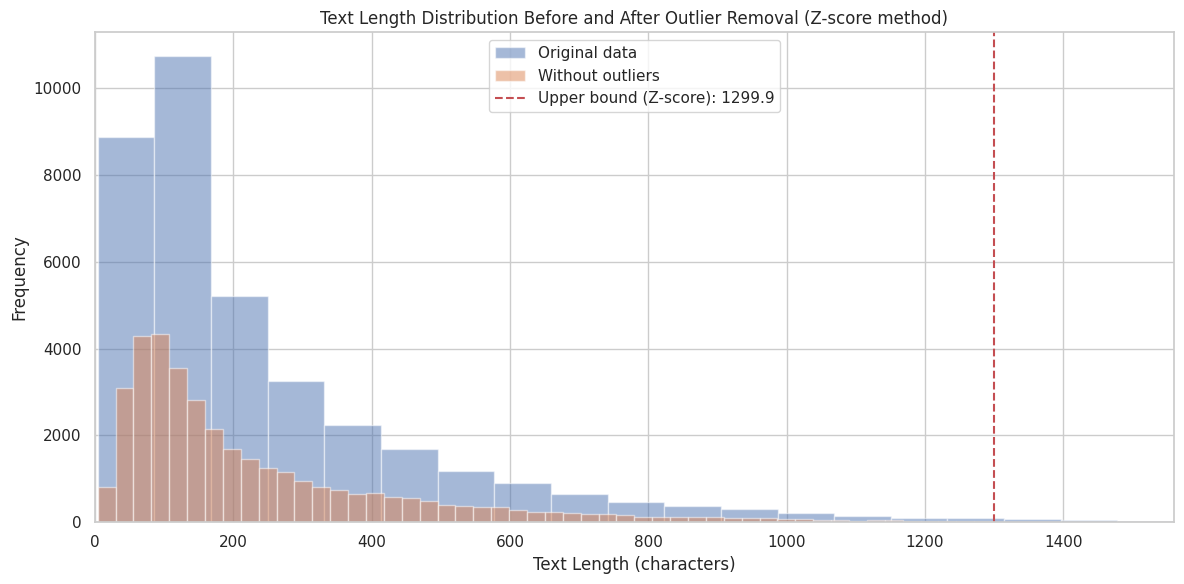

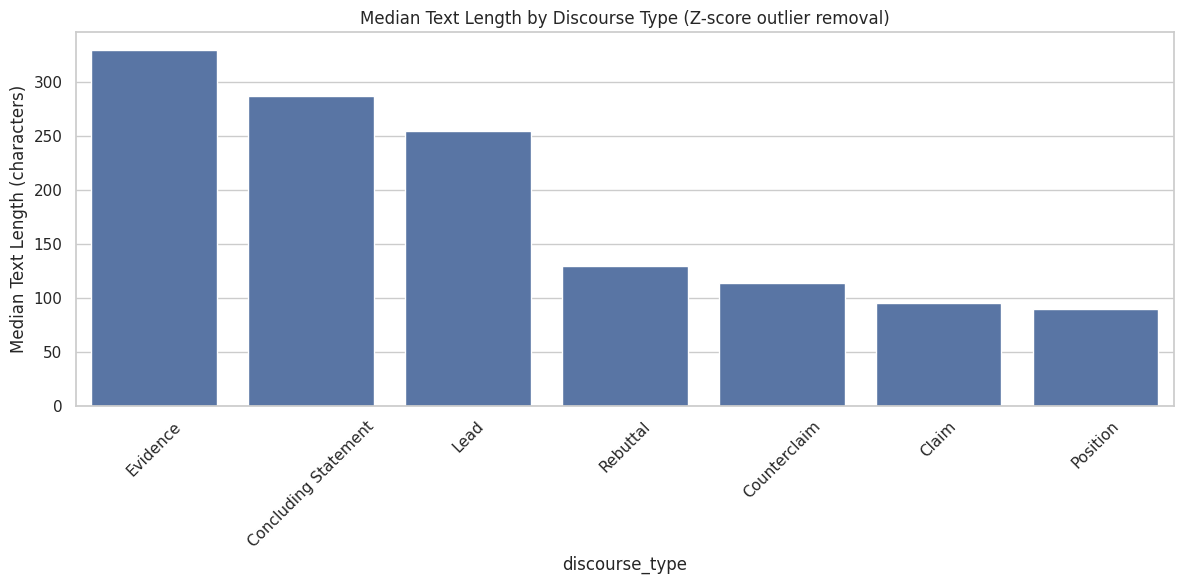

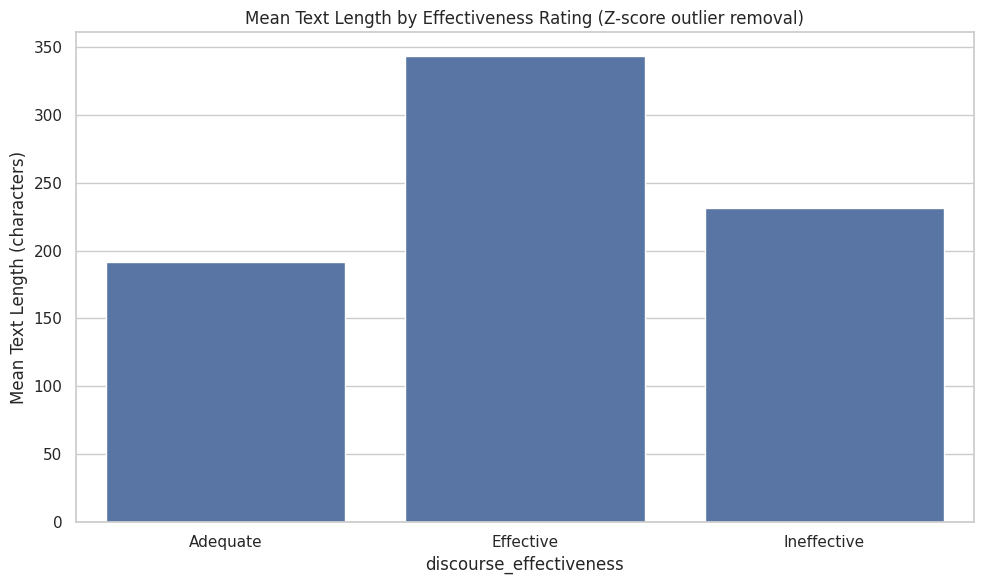

In [10]:
# Compare different outlier removal methods for text length analysis

# Method 1: Original IQR Method (1.5 * IQR)
Q1 = train_df['text_length'].quantile(0.25)
Q3 = train_df['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = max(0, Q1 - 1.5 * IQR)
upper_bound_iqr = Q3 + 1.5 * IQR
filtered_df_iqr = train_df[(train_df['text_length'] >= lower_bound_iqr) & 
                           (train_df['text_length'] <= upper_bound_iqr)]

# Method 2: More Conservative IQR (3.0 * IQR)
lower_bound_iqr3 = max(0, Q1 - 3.0 * IQR)
upper_bound_iqr3 = Q3 + 3.0 * IQR
filtered_df_iqr3 = train_df[(train_df['text_length'] >= lower_bound_iqr3) & 
                            (train_df['text_length'] <= upper_bound_iqr3)]

# Method 3: Percentile-based (remove top 1%)
upper_bound_perc = train_df['text_length'].quantile(0.99)
filtered_df_perc = train_df[train_df['text_length'] <= upper_bound_perc]

# Method 4: Z-score with higher threshold (4 standard deviations)
mean = train_df['text_length'].mean()
std = train_df['text_length'].std()
z_threshold = 4
upper_bound_z = mean + z_threshold * std
filtered_df_z = train_df[train_df['text_length'] <= upper_bound_z]

# Print comparison of methods
print("Comparison of Outlier Removal Methods:")
print(f"1. Original IQR (1.5 * IQR):")
print(f"   - Upper bound: {upper_bound_iqr:.1f}")
print(f"   - Removed: {len(train_df) - len(filtered_df_iqr)} samples ({(len(train_df) - len(filtered_df_iqr)) / len(train_df) * 100:.2f}%)")
print("\n   Statistics after IQR (1.5) outlier removal:")
print(filtered_df_iqr['text_length'].describe())

print(f"\n2. Conservative IQR (3.0 * IQR):")
print(f"   - Upper bound: {upper_bound_iqr3:.1f}")
print(f"   - Removed: {len(train_df) - len(filtered_df_iqr3)} samples ({(len(train_df) - len(filtered_df_iqr3)) / len(train_df) * 100:.2f}%)")
print("\n   Statistics after IQR (3.0) outlier removal:")
print(filtered_df_iqr3['text_length'].describe())

print(f"\n3. 99th Percentile:")
print(f"   - Upper bound: {upper_bound_perc:.1f}")
print(f"   - Removed: {len(train_df) - len(filtered_df_perc)} samples ({(len(train_df) - len(filtered_df_perc)) / len(train_df) * 100:.2f}%)")
print("\n   Statistics after 99th percentile outlier removal:")
print(filtered_df_perc['text_length'].describe())

print(f"\n4. Z-score (4 std):")
print(f"   - Upper bound: {upper_bound_z:.1f}")
print(f"   - Removed: {len(train_df) - len(filtered_df_z)} samples ({(len(train_df) - len(filtered_df_z)) / len(train_df) * 100:.2f}%)")
print("\n   Statistics after Z-score (4 std) outlier removal:")
print(filtered_df_z['text_length'].describe())

# Use the Z-score method for our visualizations
filtered_df = filtered_df_z

# Compare the distribution using Z-score method
plt.figure(figsize=(12, 6))
plt.hist(train_df['text_length'], bins=50, alpha=0.5, label='Original data')
plt.hist(filtered_df['text_length'], bins=50, alpha=0.5, label='Without outliers')
plt.axvline(x=upper_bound_z, color='r', linestyle='--', label=f'Upper bound (Z-score): {upper_bound_z:.1f}')
plt.legend()
plt.title('Text Length Distribution Before and After Outlier Removal (Z-score method)')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.xlim(0, min(2000, upper_bound_z * 1.2))  # Limit x-axis for better visualization
plt.tight_layout()
plt.show()

# For discourse type with Z-score method
plt.figure(figsize=(12, 6))
median_lengths = filtered_df.groupby('discourse_type')['text_length'].median().sort_values(ascending=False)
sns.barplot(x=median_lengths.index, y=median_lengths.values)
plt.title('Median Text Length by Discourse Type (Z-score outlier removal)')
plt.xticks(rotation=45)
plt.ylabel('Median Text Length (characters)')
plt.tight_layout()
plt.show()

# For effectiveness with Z-score method
plt.figure(figsize=(10, 6))
mean_by_effectiveness = filtered_df.groupby('discourse_effectiveness')['text_length'].mean()
sns.barplot(x=mean_by_effectiveness.index, y=mean_by_effectiveness.values)
plt.title('Mean Text Length by Effectiveness Rating (Z-score outlier removal)')
plt.ylabel('Mean Text Length (characters)')
plt.tight_layout()
plt.show()

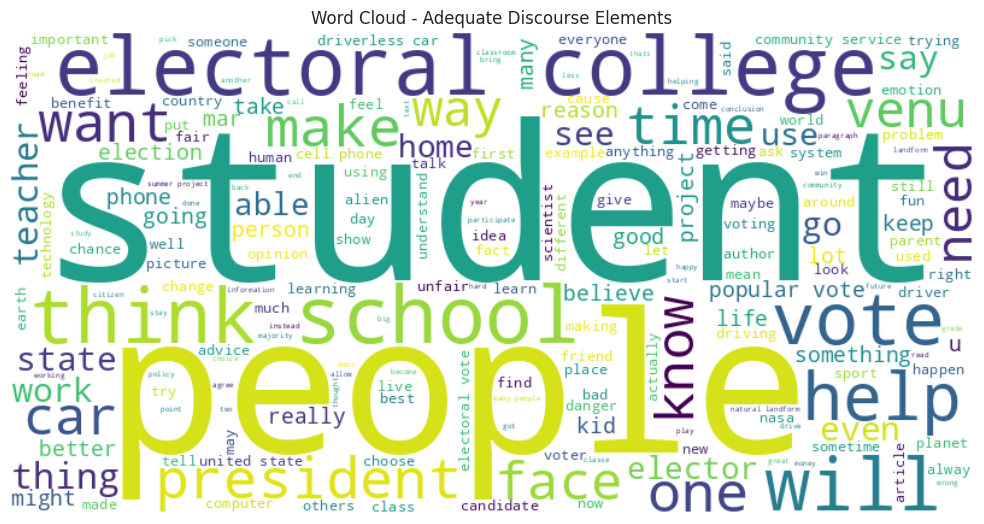

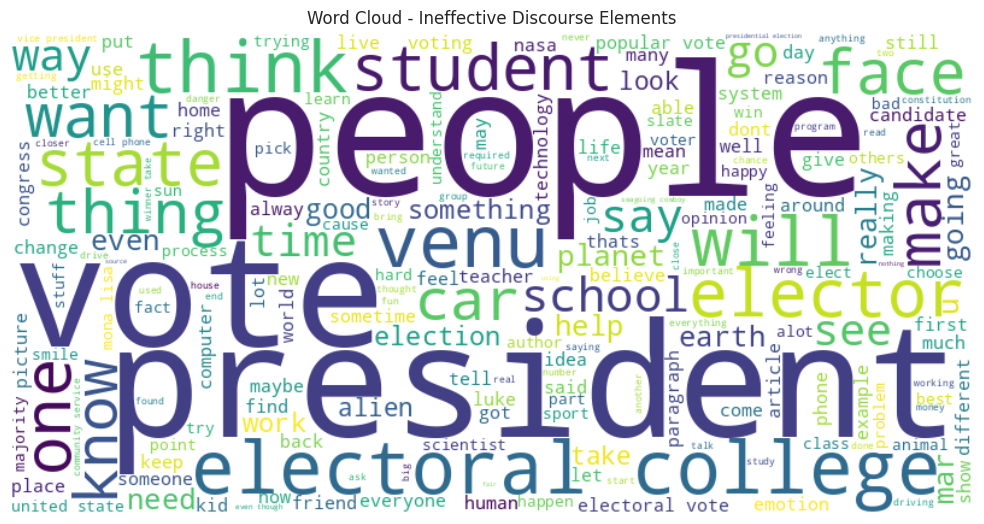

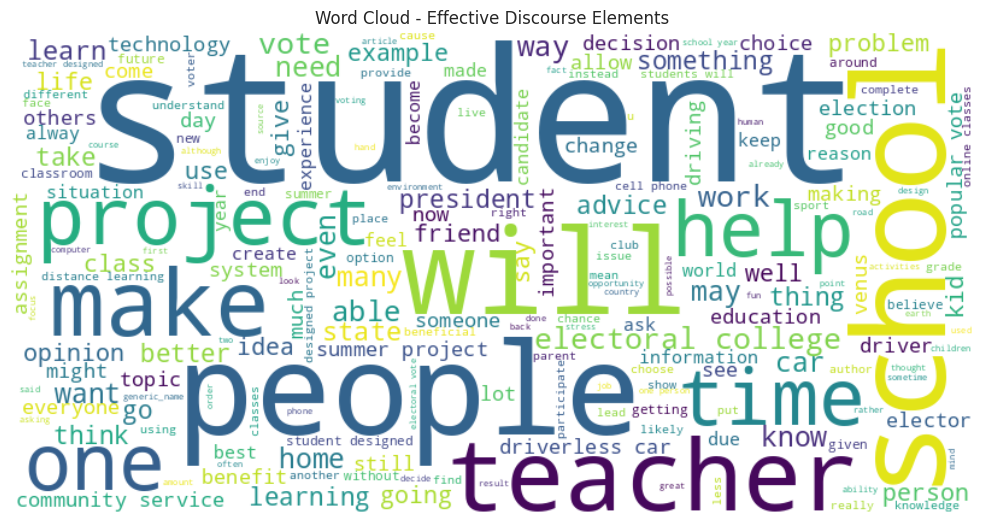

In [17]:
# Function to create wordcloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create word clouds for each effectiveness category
for effectiveness in train_df['discourse_effectiveness'].unique():
    subset = train_df[train_df['discourse_effectiveness'] == effectiveness]
    text = ' '.join(subset['discourse_text'].str.lower())
    create_wordcloud(text, f'Word Cloud - {effectiveness} Discourse Elements')

Average discourse elements per essay: 8.77
Min discourse elements: 1
Max discourse elements: 23


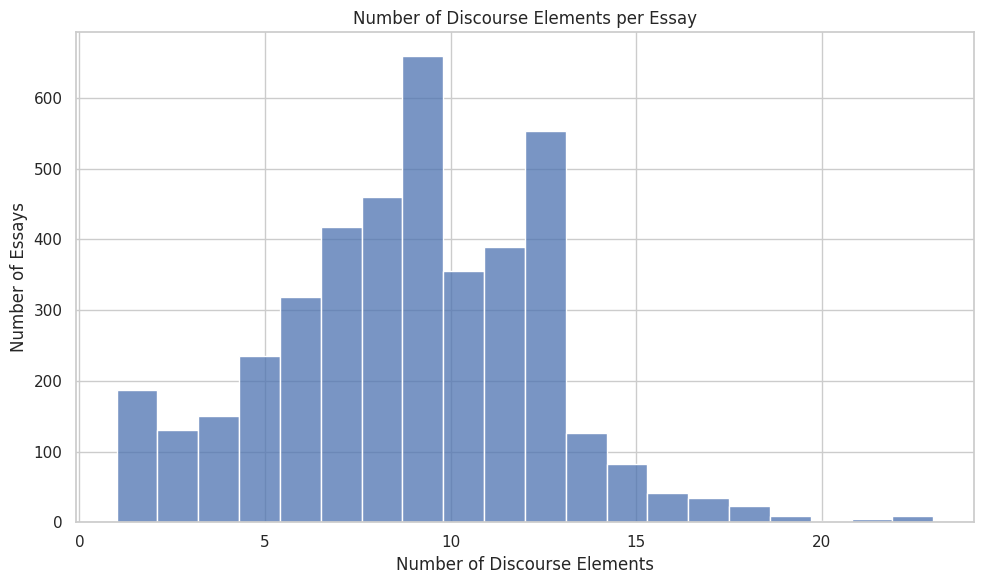

In [18]:
# Count how many discourse elements each essay has
essay_counts = train_df.groupby('essay_id').size().reset_index(name='discourse_count')

print(f"Average discourse elements per essay: {essay_counts['discourse_count'].mean():.2f}")
print(f"Min discourse elements: {essay_counts['discourse_count'].min()}")
print(f"Max discourse elements: {essay_counts['discourse_count'].max()}")

# Plot distribution of discourse count per essay
plt.figure(figsize=(10, 6))
sns.histplot(essay_counts['discourse_count'], bins=20)
plt.title('Number of Discourse Elements per Essay')
plt.xlabel('Number of Discourse Elements')
plt.ylabel('Number of Essays')
plt.tight_layout()
plt.show()

In [19]:
# Analyze how discourse types are distributed within essays
essay_type_counts = train_df.groupby(['essay_id', 'discourse_type']).size().unstack(fill_value=0)

# Get the average number of each discourse type per essay
avg_counts_per_essay = essay_type_counts.mean().sort_values(ascending=False)

print("Average number of each discourse type per essay:")
for disc_type, avg in avg_counts_per_essay.items():
    print(f"{disc_type}: {avg:.2f}")

# Count how many essays have each discourse type
essays_with_type = essay_type_counts[essay_type_counts > 0].count()
total_essays = len(essay_type_counts)

print("\nPercentage of essays containing each discourse type:")
for disc_type, count in essays_with_type.items():
    print(f"{disc_type}: {count} essays ({count/total_essays*100:.1f}%)")

Average number of each discourse type per essay:
Evidence: 2.89
Claim: 2.86
Position: 0.96
Concluding Statement: 0.80
Lead: 0.55
Counterclaim: 0.42
Rebuttal: 0.30

Percentage of essays containing each discourse type:
Claim: 3775 essays (90.1%)
Concluding Statement: 3332 essays (79.5%)
Counterclaim: 1349 essays (32.2%)
Evidence: 4167 essays (99.4%)
Lead: 2289 essays (54.6%)
Position: 4005 essays (95.6%)
Rebuttal: 1017 essays (24.3%)


In [23]:
# Let's examine some samples from each discourse type and effectiveness rating
for discourse_type in train_df['discourse_type'].unique():
    print(f"\n\n{'='*80}\nDISCOURSE TYPE: {discourse_type}\n{'='*80}")
    
    for effectiveness in train_df['discourse_effectiveness'].unique():
        samples = train_df[(train_df['discourse_type'] == discourse_type) & 
                           (train_df['discourse_effectiveness'] == effectiveness)]
        
        if len(samples) > 0:
            # Get a random sample
            sample = samples.sample(1).iloc[0]
            
            print(f"\n--- EFFECTIVENESS: {effectiveness} ---")
            print(f"Sample text (truncated to 300 chars):")
            print(f"{sample['discourse_text'][:300]}...")
            print(f"Text length: {len(sample['discourse_text'])} characters")



DISCOURSE TYPE: Lead

--- EFFECTIVENESS: Adequate ---
Sample text (truncated to 300 chars):
Have you ever thought about keeping the Elector College or changing to election by popular vote for the president of the United State? As living here in Florida most people advise to go with the Electoral College because the Electoral College always finds a way to make at least all the votes to be e...
Text length: 306 characters

--- EFFECTIVENESS: Ineffective ---
Sample text (truncated to 300 chars):
Have you ever been on a trip to cross the Alantic Ocean? A man named luke Bomberger has, and did sixteen times ...
Text length: 111 characters

--- EFFECTIVENESS: Effective ---
Sample text (truncated to 300 chars):
In the article "Driverless Cars Are Coming," the author presents both positive and negative aspects of cars that drive themselves. Although, there are bountieous reasons why driverless cars are a good thing, there are also myriads of reasons as of why this could also be a bad thing. .

In [24]:
# Summarize the key findings from our analysis
findings = {
    "dataset_stats": {
        "num_samples": len(train_df),
        "num_essays": train_df['essay_id'].nunique(),
        "avg_discourse_per_essay": train_df.groupby('essay_id').size().mean()
    },
    "class_distribution": train_df['discourse_effectiveness'].value_counts().to_dict(),
    "discourse_types": train_df['discourse_type'].value_counts().to_dict(),
    "median_text_length": train_df['text_length'].median()
}

print("Key Findings Summary:")
for key, value in findings.items():
    print(f"\n{key.replace('_', ' ').title()}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"  - {k}: {v}")
    else:
        print(f"  - {value}")

Key Findings Summary:

Dataset Stats:
  - num_samples: 36765
  - num_essays: 4191
  - avg_discourse_per_essay: 8.772369362920545

Class Distribution:
  - Adequate: 20977
  - Effective: 9326
  - Ineffective: 6462

Discourse Types:
  - Evidence: 12105
  - Claim: 11977
  - Position: 4024
  - Concluding Statement: 3351
  - Lead: 2291
  - Counterclaim: 1773
  - Rebuttal: 1244

Median Text Length:
  - 155.0
